In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn


In [12]:
data = pd.read_csv('stock_market_data-AAPL.csv')


In [13]:
data = data[['Date', 'Close']]
data = data.sort_values("Date")
data

,Date,Close
6168,1999-11-01,77.62
6167,1999-11-02,80.25
6166,1999-11-03,81.50
6165,1999-11-04,83.62
6164,1999-11-05,88.31
...,...,...
4,2024-05-02,173.03
3,2024-05-03,183.38
2,2024-05-06,181.71
1,2024-05-07,182.40


In [14]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

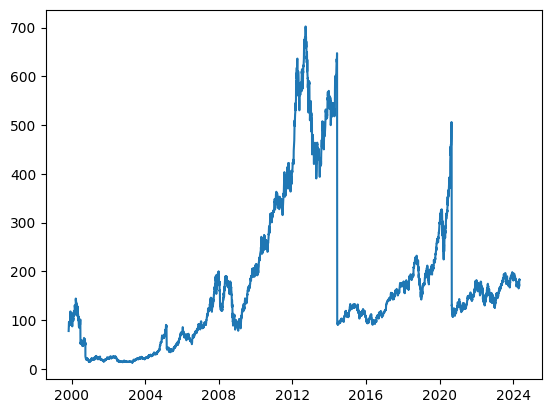

In [15]:
data['Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'], data['Close'])

In [16]:
from copy import deepcopy as dc

def setup(df, n_steps):
    df = dc(df)
    
    df.set_index('Date', inplace=True)
    
    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

lookback = 7
shifted_df = setup(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1999-11-10,91.44,89.62,96.37,88.31,83.62,81.50,80.25,77.62
1999-11-11,92.25,91.44,89.62,96.37,88.31,83.62,81.50,80.25
1999-11-12,90.62,92.25,91.44,89.62,96.37,88.31,83.62,81.50
1999-11-15,89.44,90.62,92.25,91.44,89.62,96.37,88.31,83.62
1999-11-16,91.19,89.44,90.62,92.25,91.44,89.62,96.37,88.31
...,...,...,...,...,...,...,...,...
2024-05-02,173.03,169.30,170.33,173.50,169.30,169.89,169.02,166.90
2024-05-03,183.38,173.03,169.30,170.33,173.50,169.30,169.89,169.02
2024-05-06,181.71,183.38,173.03,169.30,170.33,173.50,169.30,169.89


In [20]:
df_as_np = shifted_df.to_numpy()

df_as_np

array([[ 91.44,  89.62,  96.37, ...,  81.5 ,  80.25,  77.62],
       [ 92.25,  91.44,  89.62, ...,  83.62,  81.5 ,  80.25],
       [ 90.62,  92.25,  91.44, ...,  88.31,  83.62,  81.5 ],
       ...,
       [181.71, 183.38, 173.03, ..., 173.5 , 169.3 , 169.89],
       [182.4 , 181.71, 183.38, ..., 170.33, 173.5 , 169.3 ],
       [182.74, 182.4 , 181.71, ..., 169.3 , 170.33, 173.5 ]])

In [22]:
df_as_np.shape

(6162, 8)

In [24]:
from sklearn.preprocessing import MinMaxScaler

# Normalize data
scaler = MinMaxScaler(feature_range=(-1, 1))
normalized_df_as_np = scaler.fit_transform(df_as_np)

normalized_df_as_np

array([[-0.77264942, -0.7779326 , -0.75833841, ..., -0.80150367,
        -0.80513222, -0.8127667 ],
       [-0.77029812, -0.77264942, -0.7779326 , ..., -0.79534965,
        -0.80150367, -0.80513222],
       [-0.77502975, -0.77029812, -0.77264942, ..., -0.78173532,
        -0.79534965, -0.80150367],
       ...,
       [-0.51060989, -0.50576214, -0.53580655, ..., -0.53444222,
        -0.54663415, -0.54492148],
       [-0.50860693, -0.51060989, -0.50576214, ..., -0.54364423,
        -0.53444222, -0.54663415],
       [-0.50761996, -0.50860693, -0.51060989, ..., -0.54663415,
        -0.54364423, -0.53444222]])

In [25]:
X = normalized_df_as_np[:, 1:]
y = normalized_df_as_np[:, 0]

X.shape, y.shape

((6162, 7), (6162,))

In [26]:
X = dc(np.flip(X, axis=1))
X

array([[-0.8127667 , -0.80513222, -0.80150367, ..., -0.78173532,
        -0.75833841, -0.7779326 ],
       [-0.80513222, -0.80150367, -0.79534965, ..., -0.75833841,
        -0.7779326 , -0.77264942],
       [-0.80150367, -0.79534965, -0.78173532, ..., -0.7779326 ,
        -0.77264942, -0.77029812],
       ...,
       [-0.54492148, -0.54663415, -0.53444222, ..., -0.54663415,
        -0.53580655, -0.50576214],
       [-0.54663415, -0.53444222, -0.54364423, ..., -0.53580655,
        -0.50576214, -0.51060989],
       [-0.53444222, -0.54364423, -0.54663415, ..., -0.50576214,
        -0.51060989, -0.50860693]])

In [29]:
split_index = int(len(X) * 0.95)

split_index

5853

In [30]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5853, 7), (309, 7), (5853,), (309,))

In [31]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5853, 7, 1), (309, 7, 1), (5853, 1), (309, 1))

In [35]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

C:\Users\Administrator\AppData\Local\Temp\ipykernel_16536\1748641444.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train).float()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_16536\1748641444.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train).float()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_16536\1748641444.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test).float()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_16536\17486

(torch.Size([5853, 7, 1]),
 torch.Size([309, 7, 1]),
 torch.Size([5853, 1]),
 torch.Size([309, 1]))

In [36]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [37]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [38]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [39]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [40]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [41]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [42]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.168
Batch 200, Loss: 0.084
Batch 300, Loss: 0.021

Val Loss: 0.000
***************************************************

Epoch: 2
Batch 100, Loss: 0.010
Batch 200, Loss: 0.006
Batch 300, Loss: 0.003

Val Loss: 0.000
***************************************************

Epoch: 3
Batch 100, Loss: 0.002
Batch 200, Loss: 0.003
Batch 300, Loss: 0.001

Val Loss: 0.000
***************************************************

Epoch: 4
Batch 100, Loss: 0.001
Batch 200, Loss: 0.002
Batch 300, Loss: 0.001

Val Loss: 0.000
***************************************************

Epoch: 5
Batch 100, Loss: 0.003
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.000
***************************************************

Epoch: 6
Batch 100, Loss: 0.001
Batch 200, Loss: 0.003
Batch 300, Loss: 0.000

Val Loss: 0.000
***************************************************

Epoch: 7
Batch 100, Loss: 0.001
Batch 200, Loss: 0.000
Batch 300, Loss: 0.002

Val Loss: 0.000
*****************

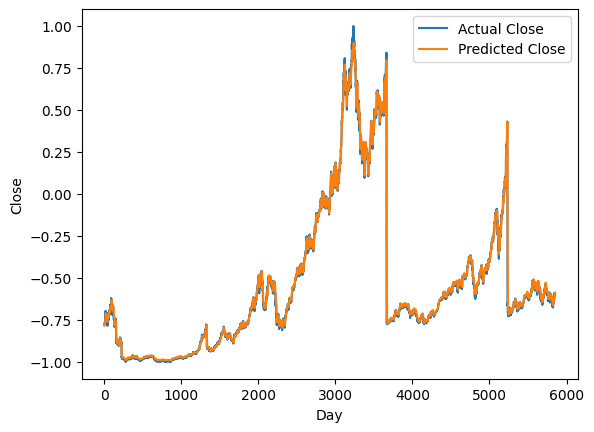

In [43]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [44]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([ 87.58801763,  89.37044348,  90.92018705, ..., 153.953674  ,
       154.13672751, 155.11983679])

In [45]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([ 91.44000565,  92.24999948,  90.61999161, ..., 151.00999279,
       153.85000185, 153.20000274])

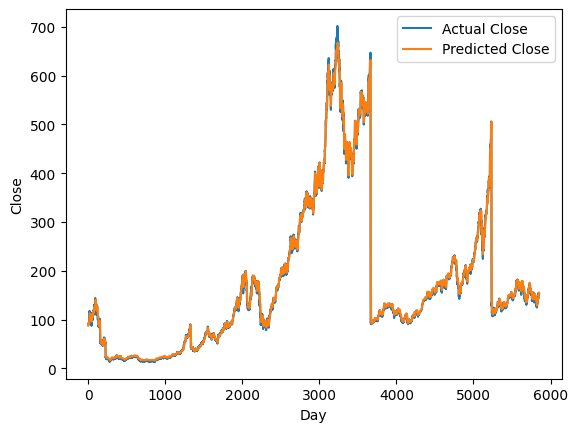

In [46]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [47]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([155.07901678, 156.03496063, 155.75010349, 155.41362587,
       153.82098843, 153.29427068, 152.92276342, 151.51591041,
       151.08756724, 150.48068786, 149.30158915, 149.05755202,
       150.73219908, 152.42957639, 152.58887299, 153.43933777,
       153.16573282, 152.56872992, 153.13396796, 153.90850095,
       154.21707394, 155.58070456, 155.8865261 , 157.28572022,
       158.93194933, 159.28411431, 160.09825585, 161.12770857,
       160.84211224, 160.66967439, 161.79109533, 162.79921405,
       164.39583493, 165.72303964, 166.2868609 , 166.1487135 ,
       166.73990551, 165.91989147, 165.08480606, 164.25208197,
       165.85048924, 166.184893  , 166.47814822, 167.18541444,
       168.1719733 , 168.42806342, 168.1190387 , 168.04571462,
       167.35902268, 167.0375959 , 168.63947329, 169.66769401,
       170.20278931, 170.25594978, 170.02825708, 169.44556581,
       172.46201669, 173.44867821, 173.30677324, 174.21448459,
       174.83889933, 174.84629128, 174.87986307, 174.69

In [48]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([155.32999413, 153.71000647, 152.55000363, 148.47999405,
       148.91000041, 149.4000048 , 146.7099908 , 147.91999198,
       147.41000879, 145.30999588, 145.90999663, 151.02999214,
       153.83000251, 151.59999388, 152.86999309, 150.59000664,
       148.4999934 , 150.46999006, 152.59000232, 152.99000966,
       155.84999753, 155.00000501, 157.40000804, 159.28000767,
       157.82999386, 158.92999867, 160.24999623, 158.27999956,
       157.6499998 , 160.76999962, 162.36000881, 164.90000723,
       166.17000643, 165.6300037 , 163.76000373, 164.6599946 ,
       162.02999916, 160.79999863, 160.10000117, 165.560006  ,
       165.20999701, 165.22999635, 166.46999654, 167.62999937,
       166.64999061, 165.02000327, 165.32999305, 163.77000341,
       163.76000373, 168.4099942 , 169.6799934 , 169.58999637,
       168.53998991, 167.45000531, 165.78999842, 173.57000892,
       173.49999069, 171.77000665, 173.55499914, 173.75000298,
       172.57000081, 172.06999676, 172.06999676, 172.68

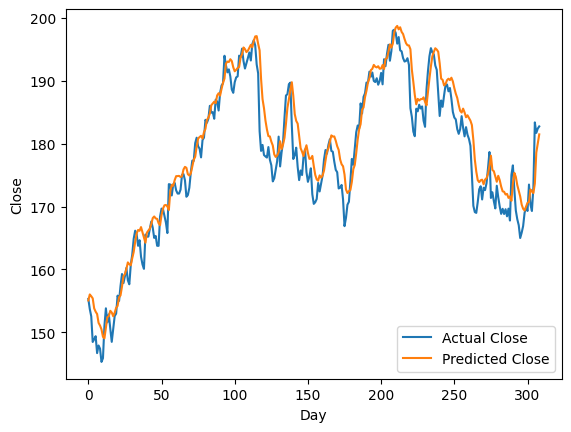

In [49]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()
